In [89]:
from bunch import Bunch
import functools
import json
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import palettable
import pandas as pd
from scipy.spatial import ConvexHull
import sys
import pneumodel.plotting as plotting
import pneumodel.trial as pn
import scipy.stats as st
from pneumodel.plotting import style_violin

In [90]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


##  Setup

In [91]:
%matplotlib inline
cubehelix = palettable.cubehelix.cubehelix1_16_r.mpl_colors
COLORS  = {'infant': cubehelix[6], 'toddler': cubehelix[10], 'vaccinated': cubehelix[11]}
MARKERS = {'infant': 'o', 'toddler': 's'}

In [92]:
OUTPUT_FOLDER = "/Volumes/Samsung USB/WCV-PAPER/wcv-trial-kenya-random-mixing"
FIGURES_FOLDER = os.path.join(OUTPUT_FOLDER, 'figures')
save_figure = functools.partial(plotting.save_figure, folder=FIGURES_FOLDER, dpi=300)

## Age distribution 

In [93]:
cfg_path = os.path.join(OUTPUT_FOLDER, 'configuration') 
with open(os.path.join(cfg_path, 'configuration.json')) as f:
  CFG = json.load(f, object_hook=lambda d: Bunch(d))

with open(os.path.join(cfg_path, CFG.population.lifespan_pmf_file)) as f:
  LIFESPAN_PMF = json.load(f, object_hook=lambda d: Bunch(d)).pmf
LIFESPAN_PMF = [0] + LIFESPAN_PMF

['/Volumes/Samsung USB/WCV-PAPER/wcv-trial-kenya-random-mixing/figures/lifespan-distribution-0.pdf',
 '/Volumes/Samsung USB/WCV-PAPER/wcv-trial-kenya-random-mixing/figures/lifespan-distribution-0.png']

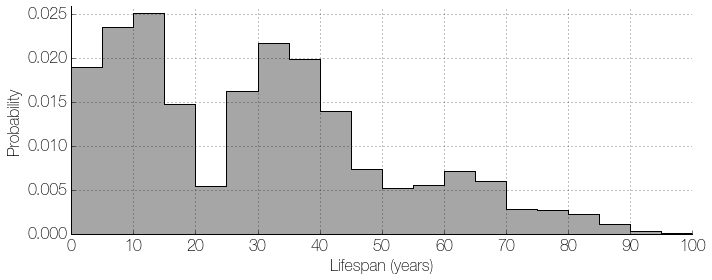

In [94]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

yrs = np.arange(len(LIFESPAN_PMF))
ax.step(yrs, LIFESPAN_PMF)

for a, b in zip(yrs[:-1], yrs[1:]):
  ax.fill_between([a, b], 0, LIFESPAN_PMF[b], facecolor='.65', edgecolor='.65', lw=1)


ax.set_ylabel('Probability')
ax.set_ylim(0, max(LIFESPAN_PMF) * 1.03)

ax.set_xlabel('Lifespan (years)')
ax.set_xlim(0, max(yrs) - 1)
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(10))

ax.grid(True)
plotting.remove_spines(ax)
fig.tight_layout()
save_figure(fig, 'lifespan-distribution')

## A sample run

In [95]:
%%time
TRA_B = pn.load_trajectories(OUTPUT_FOLDER, index_by='birth')

CPU times: user 1.36 s, sys: 85.5 ms, total: 1.44 s
Wall time: 40.1 s


In [96]:
TRA_B.keys()

['dr-10ce-toddler',
 'control-infant',
 'control-toddler',
 'dr-5ce-infant',
 'dr-3ce-toddler',
 'dr-3ce-infant',
 'dr-10ce-infant',
 'sr-1.0-6A-infant',
 'sr-1.0-infant',
 'dr-5ce-toddler',
 'sr-0.5-infant']

['/Volumes/Samsung USB/WCV-PAPER/wcv-trial-kenya-random-mixing/figures/example-using-run-0-1.pdf',
 '/Volumes/Samsung USB/WCV-PAPER/wcv-trial-kenya-random-mixing/figures/example-using-run-0-1.png']

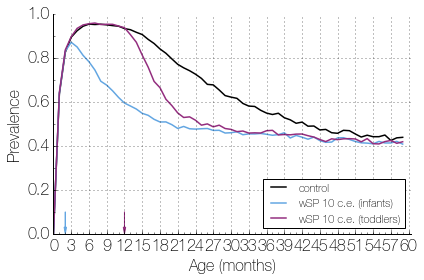

In [97]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

run = 'run-0'
num_months = 60
marker='o'
markersize=0

ax.plot(TRA_B['control-infant'][run][:num_months],  c='k', label='control', 
        marker=marker, markersize=markersize, lw=1.5)
ax.plot(TRA_B['dr-10ce-infant'][run][:num_months],  c=COLORS['infant'], label='wSP 10 c.e. (infants)', 
        marker=marker, markersize=markersize, lw=1.5)
ax.plot(TRA_B['dr-10ce-toddler'][run][:num_months], c=COLORS['toddler'], label='wSP 10 c.e. (toddlers)', 
        marker=marker, markersize=markersize, lw=1.5)

ax.arrow(60, 0.1, 0.0, -0.1, fc=COLORS['infant'], ec=COLORS['infant'], 
         head_width=12, head_length=0.03, length_includes_head=True)
ax.arrow(360, 0.1, 0.0, -0.1, fc=COLORS['toddler'], ec=COLORS['toddler'], 
         head_width=12, head_length=0.03, length_includes_head=True)

ax.set_ylabel('Prevalence')
ax.set_ylim(0, 1.0)
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))

ax.set_xlabel('Age (months)')
ax.set_xlim(0, num_months * 30 + 10)
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(90))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(30))
ax.set_xticklabels('{:.0f}'.format(x / 30) for x in ax.get_xticks())

ax.grid(True)

ax.legend(loc='lower right', fontsize=11, frameon=True)

plotting.remove_spines(ax)
fig.tight_layout()

save_figure(fig, 'example-using-{}'.format(run), bbox_inches='tight', bbox_extra_artist=[])

## Analysis

### Prev + Duration + Incidence vs Age

In [98]:
%%time
TRIALS = pn.load_trials(OUTPUT_FOLDER)

CPU times: user 52.2 s, sys: 17.3 s, total: 1min 9s
Wall time: 2min 6s


In [99]:
interval_in_months = 6 # interval length (in months)
start_month = 0 # minimum month
end_month = 60 # maximum number of months
SAMPLING_DAYS = np.arange(start_month * 30, end_month * 30 , interval_in_months * 30)
print SAMPLING_DAYS
print SAMPLING_DAYS / 30

[   0  180  360  540  720  900 1080 1260 1440 1620]
[ 0  6 12 18 24 30 36 42 48 54]


In [100]:
%%time
MEAN_DURATIONS = {}
for arm_name in ['control-infant', 'dr-10ce-infant', 'control-toddler', 'dr-10ce-toddler']:
  MEAN_DURATIONS[arm_name] = {}
  for d in SAMPLING_DAYS:
    MEAN_DURATIONS[arm_name][d] = [pn.get_mean_duration(t.arms[arm_name], interval_in_months * 30, first_day=d) for t in TRIALS]

CPU times: user 21.4 s, sys: 3.04 s, total: 24.4 s
Wall time: 27.1 s


In [101]:
%%time
INCIDENCES = {}
for arm_name in ['control-infant', 'dr-10ce-infant', 'control-toddler', 'dr-10ce-toddler']:
  INCIDENCES[arm_name] = {}
  for d in SAMPLING_DAYS:
    INCIDENCES[arm_name][d] = [pn.get_incidence(t.arms[arm_name], interval_in_months * 30, first_day=d) for t in TRIALS]

CPU times: user 43.4 s, sys: 450 ms, total: 43.8 s
Wall time: 45.8 s


33.0125990838
20.7330164401
19.4168277996
18.6848153386
18.2147657365
17.9333214545
17.8004160104
17.6714500908
17.603625916
17.5636098175


['/Volumes/Samsung USB/WCV-PAPER/wcv-trial-kenya-random-mixing/figures/prev-dur-inc-vs-age-infant-1.pdf',
 '/Volumes/Samsung USB/WCV-PAPER/wcv-trial-kenya-random-mixing/figures/prev-dur-inc-vs-age-infant-1.png']

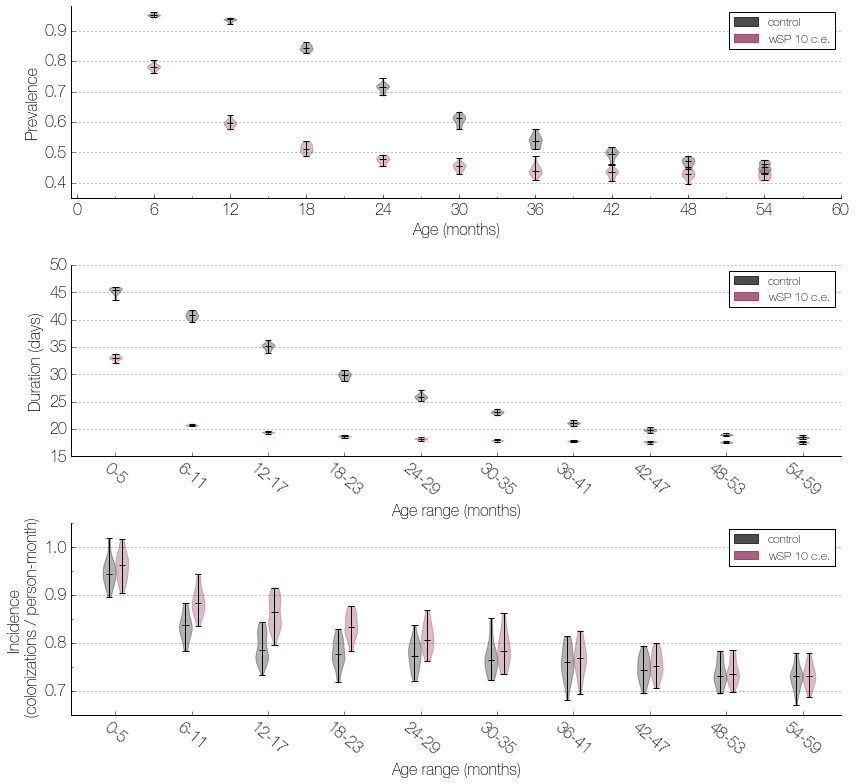

In [102]:
fig, axes = plt.subplots(3, 1, figsize=(12, 11))

dsb_prev = np.arange(start_month * 30, end_month * 30, 3 * 30) # days since birth

age_group = 'infant'
arm_one = 'control-{}'.format(age_group)
arm_two = 'dr-10ce-{}'.format(age_group)

w = 1
delta = 0.5

# Prevalence vs age
ax = axes[0] 
for d in SAMPLING_DAYS:
  
  ys = TRA_B[arm_one].loc[d]
  violin_parts = ax.violinplot(ys, [d / 30], points=80, vert=True, widths=w, 
                               showmeans=False, showextrema=True, showmedians=True)
  style_violin(violin_parts, 'k', 'k')
  
  ys = TRA_B[arm_two].loc[d]
  violin_parts = ax.violinplot(ys, [d / 30], points=80, vert=True, widths=w, 
                               showmeans=False, showextrema=True, showmedians=True)
  style_violin(violin_parts, COLORS['vaccinated'], 'k')

ax.set_ylabel('Prevalence')
ax.set_ylim(0.35, 0.98)  

ax.set_xlabel('Age (months)')
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(6))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(3))


# Mean duration  
ax = axes[1]
for d in sorted(SAMPLING_DAYS):
  w = 1.0
  ys = MEAN_DURATIONS[arm_one][d]
  v = ax.violinplot(ys, [d / 30 + interval_in_months / 2], points=80, widths=w,
                    showmeans=False, showextrema=True, showmedians=True)
  style_violin(v, 'k', 'k')
  
  ys = MEAN_DURATIONS[arm_two][d]
  v = ax.violinplot(ys, [d / 30 + interval_in_months / 2], points=80, widths=w,
                    showmeans=False, showextrema=True, showmedians=True)
  style_violin(v, COLORS['vaccinated'], 'k')
  
  print np.mean(ys)

ax.set_xlabel('Age range (months)')
ax.set_xticks(SAMPLING_DAYS / 30 + (interval_in_months / 2))
ax.set_xticklabels(['{:.0f}-{:.0f}'.format(d / 30, d / 30 + (interval_in_months - 1)) for d in SAMPLING_DAYS], rotation=-40)

ax.set_ylabel('Duration (days)')
ax.yaxis.grid(True)



# Incidence
ax = axes[2]
for d in sorted(SAMPLING_DAYS):
  w = 1.0
  ys = 30 * np.array(INCIDENCES[arm_one][d])
  v = ax.violinplot(ys, [d / 30 + interval_in_months / 2 - delta], points=80, widths=w,
                    showmeans=False, showextrema=True, showmedians=True)
  style_violin(v, 'k', 'k')

  ys = 30 * np.array(INCIDENCES[arm_two][d])
  v = ax.violinplot(ys, [d / 30 + interval_in_months / 2 + delta], points=80, widths=w,
                    showmeans=False, showextrema=True, showmedians=True)
  style_violin(v, COLORS['vaccinated'], 'k')

ax.set_xticks(SAMPLING_DAYS / 30 + (interval_in_months / 2))
ax.set_xticklabels(['{:.0f}-{:.0f}'.format(d / 30, d / 30 + (interval_in_months - 1)) for d in SAMPLING_DAYS], rotation=-40)
ax.set_xlabel('Age range (months)')

ax.set_ylabel('Incidence\n (colonizations / person-month)')
ax.yaxis.grid(True)
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.1))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))


# more plotting
for ax in axes:
  plotting.remove_spines(ax)
  ax.yaxis.grid(True)
  ax.set_xlim(-0.5)
  
for ax in axes:
  patches = []
  for label, color in {'control': 'k', 'wSP 10 c.e.': COLORS['vaccinated']}.iteritems():
    patches.append(mpl.patches.Patch(color=color, label=label, alpha=0.7))
  lgd = ax.legend(handles=patches, frameon=True, fontsize=12, loc='upper right')
    
fig.tight_layout()
plt.subplots_adjust(hspace=0.35)

save_figure(fig, 'prev-dur-inc-vs-age-{}'.format(age_group))

### Prev vs Age

In [103]:
TRA_B['control-infant'].head()

,run-0,run-1,run-2,run-3,run-4,run-5,run-6,run-7,run-8,run-9,...,run-15,run-16,run-17,run-18,run-19,run-20,run-21,run-22,run-23,run-24
dsb,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
30,0.635817,0.643487,0.638894,0.649499,0.628932,0.673146,0.641555,0.644217,0.674549,0.648827,...,0.644689,0.627958,0.651643,0.613828,0.621194,0.627982,0.636892,0.643172,0.660256,0.639423
60,0.825206,0.828112,0.830257,0.830692,0.825808,0.846030,0.831894,0.834270,0.848534,0.834404,...,0.835809,0.809361,0.839687,0.810632,0.822833,0.817068,0.828955,0.830321,0.843361,0.829787
90,0.893955,0.889559,0.896039,0.896884,0.901929,0.915863,0.895858,0.907061,0.910499,0.905049,...,0.905346,0.900785,0.903355,0.887505,0.893690,0.892218,0.898193,0.902655,0.905278,0.897003
120,0.923572,0.931479,0.931347,0.932152,0.932582,0.939912,0.931305,0.933306,0.940560,0.932661,...,0.933977,0.931195,0.933025,0.917337,0.921265,0.929938,0.933776,0.934179,0.934311,0.931062


['/Volumes/Samsung USB/WCV-PAPER/wcv-trial-kenya-random-mixing/figures/prevalence-vs-age-control-infant-1.pdf',
 '/Volumes/Samsung USB/WCV-PAPER/wcv-trial-kenya-random-mixing/figures/prevalence-vs-age-control-infant-1.png']

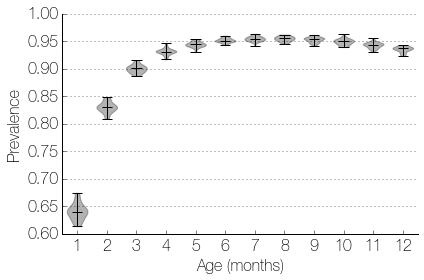

In [104]:
m, n = 1, 13
dsb = [30 * k for k in range(m, n)] # days since birth
arm_name = 'control-infant'

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
for d in dsb:
  ys = TRA_B[arm_name].loc[d]
  violin_parts = ax.violinplot(ys, [d / 30], points=100, vert=True, widths=0.7, 
                               showmeans=False, showextrema=True, showmedians=True)
  style_violin(violin_parts, 'k', 'k')

ax.set_xlabel('Age (months)')
ax.set_xlim(m - 0.5, n - 0.5)
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))

ax.set_ylabel('Prevalence')
#ax.set_ylim(0.45, 0.95)
ax.yaxis.grid(True)
  
plotting.remove_spines(ax)
fig.tight_layout()

save_figure(fig, 'prevalence-vs-age-{}'.format(arm_name))

###  Duration vs Age

In [105]:
%%time
TRIALS = pn.load_trials(OUTPUT_FOLDER)

CPU times: user 53.9 s, sys: 19.1 s, total: 1min 12s
Wall time: 2min 12s


In [106]:
%%time
L = 6 * 30 # interval length (in days)
m = 1      
n = 10
dsb = np.array([i * L for i in range(m, n)])
arm_name = 'control-toddler'

mean_durations = {}
for d in dsb:
  mean_durations[d] = [pn.get_mean_duration(t.arms[arm_name], L, first_day=d) for t in TRIALS]

CPU times: user 5.12 s, sys: 901 ms, total: 6.02 s
Wall time: 7.27 s


6, 40.73, 39.57, 41.60
12, 35.12, 34.01, 36.36
18, 29.83, 28.75, 30.89
24, 25.88, 25.09, 26.72
30, 23.06, 22.18, 23.90
36, 21.14, 20.34, 21.73
42, 19.82, 19.40, 20.17
48, 19.01, 18.65, 19.47
54, 18.44, 18.20, 18.78


['/Volumes/Samsung USB/WCV-PAPER/wcv-trial-kenya-random-mixing/figures/duration-vs-age-control-toddler-1.pdf',
 '/Volumes/Samsung USB/WCV-PAPER/wcv-trial-kenya-random-mixing/figures/duration-vs-age-control-toddler-1.png']

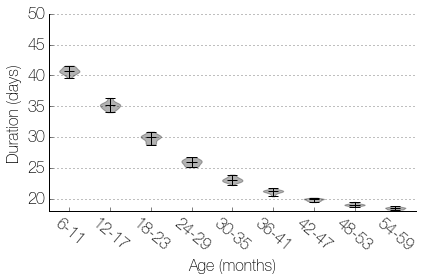

In [107]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
for d in sorted(mean_durations.iterkeys()):
  ys = mean_durations[d]
  print '{:.0f}, {:.2f}, {:.2f}, {:.2f}'.format(d / 30, np.mean(ys), np.min(ys), np.max(ys))
  v = ax.violinplot(ys, [d / L], points=80, widths=0.5,
                    showmeans=False, showextrema=True, showmedians=True)
  style_violin(v, 'k', 'k')

ax.set_xlabel('Age (months)')
ax.set_xlim(m - 0.5, n - 0.5)
ax.set_xticks(dsb / L)
ax.set_xticklabels(['{:.0f}-{:.0f}'.format(d / 30, d / 30 + (L / 30 - 1)) for d in dsb], rotation=-40)

ax.set_ylabel('Duration (days)')
ax.yaxis.grid(True)
ax.set_ylim(18, 50)

plotting.remove_spines(ax)
fig.tight_layout()
save_figure(fig, 'duration-vs-age-{}'.format(arm_name))

### Figure 2

Read in the data

In [108]:
%%time
TRA_D = pn.load_trajectories(os.path.join(OUTPUT_FOLDER), index_by='last_dose')

CPU times: user 1.22 s, sys: 57.9 ms, total: 1.28 s
Wall time: 1.57 s


Example of the data

In [109]:
TRA_D['control-infant'].head()

,run-0,run-1,run-2,run-3,run-4,run-5,run-6,run-7,run-8,run-9,...,run-15,run-16,run-17,run-18,run-19,run-20,run-21,run-22,run-23,run-24
dsv,,,,,,,,,,,,,,,,,,,,,
-60,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
-30,0.635817,0.643487,0.638894,0.649499,0.628932,0.673146,0.641555,0.644217,0.674549,0.648827,...,0.644689,0.627958,0.651643,0.613828,0.621194,0.627982,0.636892,0.643172,0.660256,0.639423
0,0.825206,0.828112,0.830257,0.830692,0.825808,0.846030,0.831894,0.834270,0.848534,0.834404,...,0.835809,0.809361,0.839687,0.810632,0.822833,0.817068,0.828955,0.830321,0.843361,0.829787
30,0.893955,0.889559,0.896039,0.896884,0.901929,0.915863,0.895858,0.907061,0.910499,0.905049,...,0.905346,0.900785,0.903355,0.887505,0.893690,0.892218,0.898193,0.902655,0.905278,0.897003
60,0.923572,0.931479,0.931347,0.932152,0.932582,0.939912,0.931305,0.933306,0.940560,0.932661,...,0.933977,0.931195,0.933025,0.917337,0.921265,0.929938,0.933776,0.934179,0.934311,0.931062


['/Volumes/Samsung USB/WCV-PAPER/wcv-trial-kenya-random-mixing/figures/prevalence-sample-size-by-ce-2.pdf',
 '/Volumes/Samsung USB/WCV-PAPER/wcv-trial-kenya-random-mixing/figures/prevalence-sample-size-by-ce-2.png']

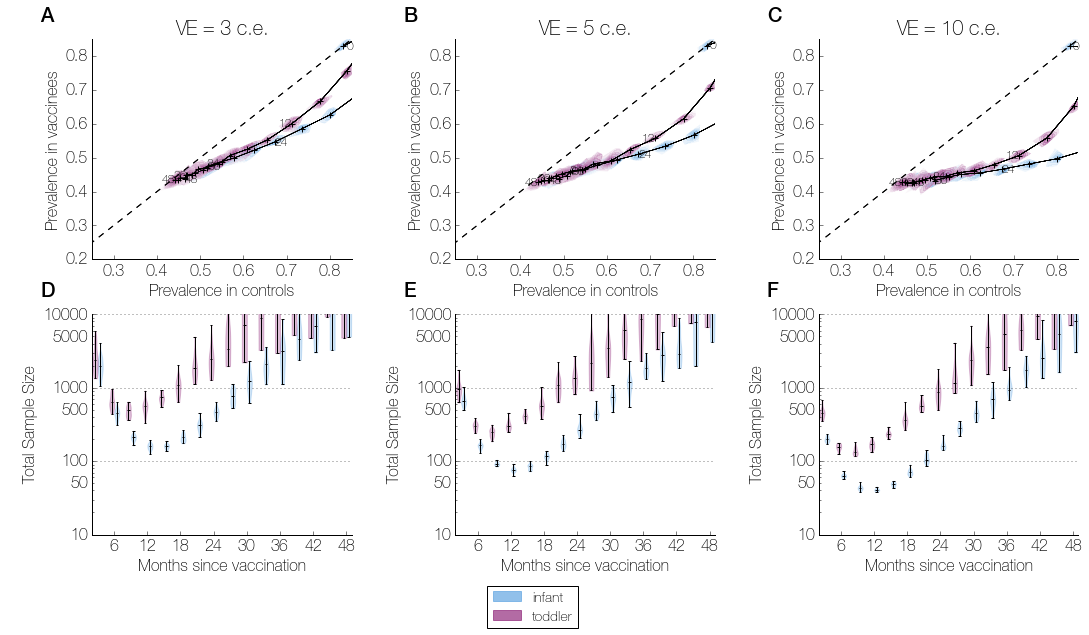

In [110]:
arm_prefixes = ('dr-3ce-{}', 'dr-5ce-{}', 'dr-10ce-{}')
age_groups = ['infant', 'toddler']
dsv = [3 * 30 * k for k in range(17)] # days since vaccination
trajectories = TRA_D
filename = 'prevalence-sample-size-by-ce' # for figure and corresponding text file
textfile = open(os.path.join(FIGURES_FOLDER, filename + '.txt'), 'w')
write = lambda s='': textfile.write(s + '\n')

fig, all_axes = plt.subplots(2, len(arm_prefixes), figsize=(5 * len(arm_prefixes), 8), sharey=False)

#########################################
# Plot prevalence in two arms over time #
#########################################
# Limits for Kenya
# xmin, xmax = 0.45, 0.95
# ymin, ymax = 0.35, 0.95

# Limits for Indonesia
# xmin, xmax = 0.35, 0.75
# ymin, ymax = 0.2, 0.75

# Limits for random mixing
# xmin, xmax = 0.45, 1.00
# ymin, ymax = 0.35, 0.95

# Limits for changing
xmin, xmax = 0.25, 0.85
ymin, ymax = 0.20, 0.85

axes = all_axes[0]

for k, age_group in enumerate(age_groups):
  arm_x = 'control-{}'.format(age_group)
  arm_ys = [s.format(age_group) for s in arm_prefixes]

  for ax, arm_y in zip(axes, arm_ys):
    write()
    write(arm_y)
    
    dots = [] # so we can connect the dots later
    for j, d in enumerate(dsv):
      xs = trajectories[arm_x].loc[d]
      ys = trajectories[arm_y].loc[d]
      points = np.array([xs, ys])
      
      xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
      positions = np.vstack([xx.ravel(), yy.ravel()])
      kernel = st.gaussian_kde(points)
      f = np.reshape(kernel(positions).T, xx.shape)

      hull = ConvexHull(points.T)
      hull_points = np.array([points.T[hull.vertices, 0], points.T[hull.vertices, 1]])
      hull_clip_poly = mpl.patches.Polygon(hull_points.T, fc='none', ec=COLORS[age_group], transform=ax.transData, alpha=0.5)
      #ax.add_patch(hull_clip_poly)
      
      cmap = mpl.colors.LinearSegmentedColormap.from_list('mycmap', [(0, 'white'), (1.0, COLORS[age_group])])
      cfset = ax.contourf(xx, yy, f, cmap=cmap, alpha=0.5)
      for c in cfset.collections:
        c.set_clip_path(hull_clip_poly)
        
      ax.plot(np.median(xs), np.median(ys), marker='+', mec='k', mew=1)
      dots.append((np.median(xs), np.median(ys)))
      write('\t({:.0f}, {:.2f}c, {:.2f}v)'.format(d / 30, np.median(xs), np.median(ys)))
    
      if (d / 30) % 12 == 0:
        offset = 0.015
        if k == 0:
          text_x = np.median(xs) + offset
        else:
          text_x = np.median(xs) - offset
        text_y = np.median(ys)
        ax.annotate(str(d / 30), (text_x, text_y), fontsize=12, ha='center', va='center')
        
      # connect the dots
      ax.plot(*zip(*dots), ls='-', lw=0.5, c='k', alpha=1, zorder=10)
      
    # label axes, etc.
    ax.set_xlabel('Prevalence in controls')
    ax.set_xlim(xmin, xmax)
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(0.1))

    ax.set_ylabel('Prevalence in vaccinees')
    ax.set_ylim(ymin, ymax)
    ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.1))

    lower = min(xmin, ymin)
    upper = max(ymax, xmax)
    ax.plot((lower, upper), (lower, upper), lw=1, ls='--')
    ax.set_title('VE = ' + arm_y.split('ce')[0][3:] + ' c.e.')
    plotting.remove_spines(ax)

    
##############################
# Plot sample size over time #
##############################

axes = all_axes[1]
for k, age_group in enumerate(age_groups):
  arm_x = 'control-{}'.format(age_group)
  arm_ys = [s.format(age_group) for s in arm_prefixes]
  

  for ax, arm_y in zip(axes, arm_ys):
    write()
    write(arm_y)
    for d in dsv:    
      if d == 0:
        continue
        
      xs = trajectories[arm_x].loc[d]
      ys = trajectories[arm_y].loc[d]
      zs = np.array([pn.sample_size(x, y) for (x, y) in zip(xs, ys)])
      
      write('\t({:.0f}, {:.2f})'.format(d / 30, np.median(zs)))
      
      w = 0.9
      xoffset = (2 * (k == 0) - 1) * (w / 2) + 0.02
      violin_parts = ax.violinplot(zs, [d / 30 + xoffset], points=80, vert=True, widths=w,
                      showmeans=False, showextrema=True, showmedians=True)
    
      style_violin(violin_parts, COLORS[age_group], 'k')
    
    ax.set_xlabel('Months since vaccination')
    ax.xaxis.set_ticks([d / 30 for d in dsv[::2]])
    ax.xaxis.set_ticklabels(['{:.0f}'.format(x) for x in ax.get_xticks()])
    ax.set_xlim(2, 49)

    ax.set_ylabel('Total Sample Size')
    ax.yaxis.grid(True, which='major')
    ax.set_ylim(1e1, 1e4)
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())

    def show_only_some(x, pos):
      s = str(int(x))
      if s[0] in ('5'):
          return s
      return ''
    ax.yaxis.set_minor_formatter(mpl.ticker.FuncFormatter(show_only_some))

    plotting.remove_spines(ax)

panel_labels = []
for label, ax in zip('ABCDEF', all_axes.flatten()):
  t = ax.text(-0.2, 1.08, label, fontsize=20, 
              fontweight='medium', transform=ax.transAxes)
  panel_labels.append(t)
  

ax = all_axes[1][1]
patches = [mpl.patches.Patch(color=COLORS[a], label=a, alpha=0.7) for a in age_groups]
lgd = ax.legend(handles=patches, frameon=True, fontsize=14, bbox_to_anchor=(0.5, -0.2))

fig.tight_layout()
plt.subplots_adjust(hspace=0.25, wspace=0.4)

textfile.close()

save_figure(fig, filename, bbox_inches='tight', bbox_extra_artist=[panel_labels] + [lgd])